<html>
<head>
	<title></title>
</head>
<body>
<h1 style="text-align: center;line-height: 120%;">ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ «МОСКОВСКИЙ ЭНЕРГЕТИЧЕСКИЙ ИНСТИТУТ» Кафедра «РЗиАЭ»</h1>
<h2 style="text-align: center;line-height: 20%;">Лабораторная работа №1</h2>

<h3 style="text-align: center;line-height: 80%;"><em>МЕТОД K-БЛИЖАЙШИХ СОСЕДЕЙ. ЛОГИСТИЧЕСКАЯ РЕРГЕССИЯ   </em></h3>
    
<h3 style="text-align: center;line-height: 60%;"><em>по дисциплине: "Применение искусственного интеллекта в электроэнергетике"   </em></h3>

    
<p style="text-align: right;line-height: 40%;"> Выполнил: студент группы Э-13м-19</p>

<p style="text-align: right;line-height: 40%;">Антонов И.И.</p>

<p style="text-align: right;line-height: 40%;">Принял: Нухулов С.М.</p>
<h4 style="text-align: center;line-height: 100%;"><em> Москва, 2020</em></h3>
</body>
</html>

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

## Пункт 1. Подготовка данных для обучения

In [2]:
data = pd.read_csv('breast_cancer.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [3]:
# конвертация категориального целевого признака в числовой, удаление лишних данных
data['diagnosis'] = data['diagnosis'].map({'B' : 1, 'M' : 0})
data.drop(['id', 'Unnamed: 32'], inplace=True, axis=1)

## Пункт 2.

In [4]:
# Разделение данных
Y = data['diagnosis']
X = data.drop('diagnosis', axis = 1)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size = 0.3, random_state = 17)

knn = KNeighborsClassifier(n_neighbors = 5)

In [5]:
# Обучение модели
#%%time
knn.fit(X_train, y_train);

In [6]:
# Проверка качества модели
#Качество прогнозов будем проверять с помощью простой метрики – доли правильных ответов
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

0.9239766081871345

In [7]:
# Проверка качества модели на обучающей и тестовых выборках с изменением числа соседей
neighbors = range(1,51)
accuracy_train = []
accuracy_holdout = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_holdout)
    accuracy_train.append(accuracy_score(y_train, knn.predict(X_train)))
    accuracy_holdout.append(accuracy_score(y_holdout, knn.predict(X_holdout)))

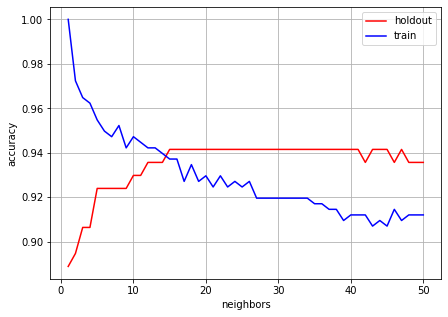

In [8]:
f=plt.figure(figsize=(7,5))
plt.plot(neighbors, accuracy_holdout, "r", label = 'holdout')
plt.plot(neighbors, accuracy_train, "b", label = 'train')
plt.ylabel('accuracy')
plt.xlabel('neighbors')
plt.legend()
plt.grid();

## Пункт 3.

In [9]:
# Создание генератора разбиений для кросс валидации по пяти блокам
kf = KFold(n_splits = 5, shuffle = True)

## Пункт 4.

In [10]:
# Поиск оптимального числа соседей
accuracy = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn, X, Y, cv = kf, scoring = 'accuracy')
    accuracy.append(score.mean())

max accuracy: 0.9402577239559073


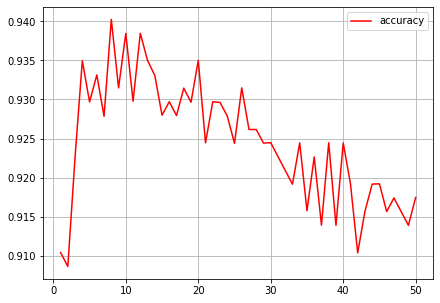

In [11]:
f=plt.figure(figsize=(7,5))
plt.plot(neighbors, accuracy, "r", label = 'accuracy')
plt.legend()
plt.grid();
print(f'max accuracy: {max(accuracy)}')

In [12]:
# Поиск оптимального числа соседей через GridSearchCV
knn_params ={'n_neighbors' : list(range(1, 51))}
knn_grid = GridSearchCV(knn, knn_params, cv=kf)

In [13]:
%%time
knn_grid.fit(X, Y);

Wall time: 3.33 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(n_neighbors=50),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [14]:
knn_grid.best_score_, knn_grid.best_params_

(0.9385343890700202, {'n_neighbors': 14})

## Пункт 4.

In [15]:
# Поиск оптимального значения C для логистической регрессии используя кросс валидацию
logit = LogisticRegression(n_jobs=-1, random_state=17)
C = list(np.arange(0.01,1,0.01))

In [16]:
%%time
logit.fit(X, Y);

Wall time: 2.53 s


LogisticRegression(n_jobs=-1, random_state=17)

In [17]:
%%time
logit_params ={'C' : C}
logit_grid = GridSearchCV(logit, logit_params, cv=kf)
logit_grid.fit(X, Y);

Wall time: 35.6 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(n_jobs=-1, random_state=17),
             param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05,
                               0.060000000000000005, 0.06999999999999999, 0.08,
                               0.09, 0.09999999999999999, 0.11, 0.12, 0.13,
                               0.14, 0.15000000000000002, 0.16, 0.17,
                               0.18000000000000002, 0.19, 0.2,
                               0.21000000000000002, 0.22, 0.23,
                               0.24000000000000002, 0.25, 0.26, 0.27, 0.28,
                               0.29000000000000004, 0.3, ...]})

In [18]:
logit_grid.best_score_, logit_grid.best_params_

(0.9542928116752059, {'C': 0.79})

## Пункт 5.

In [19]:
# Масштабирование признаков, повторение опытов.
scaler = StandardScaler()
X_scaling = scaler.fit_transform(X)

In [20]:
knn_grid = GridSearchCV(knn, knn_params, cv=kf)
knn_grid.fit(X_scaling, Y)
knn_grid.best_score_, knn_grid.best_params_

(0.9683744760130415, {'n_neighbors': 3})

In [21]:
logit_grid = GridSearchCV(logit, logit_params, cv=kf)
logit_grid.fit(X_scaling, Y)
logit_grid.best_score_, logit_grid.best_params_

(0.9789318428815401, {'C': 0.34})

Выводы: в ходе выполнения работы мы получили практические навыки работы с методами классификации